This is the work for reproducing Alphafold 1 using pytorch and Signatory path reconstruction. This work is done for Oxford Summer Project, under supervision of Dr.Cris Salvi. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
#os.chdir("/content/drive/MyDrive/Colab Notebook/alphafold_pytorch-29bd20b0ca0ccd31d984a7dc53f0302d945a2ddc/")
os.chdir("/content/drive/MyDrive/Colab Notebooks/alphafold_pytorch/alphafold_pytorch-29bd20b0ca0ccd31d984a7dc53f0302d945a2ddc/")

In [5]:
!pip install signatory
!pip install Biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Created wheel for signatory: filename=signatory-1.2.6.1.9.0-cp37-cp37m-linux_x86_64.whl size=7554194 sha256=5d05077052304f87d5ea7884b8572327948c1bfbb855633b7abb66263b5077db
  Stored in directory: /root/.cache/pip/wheels/12/ff/e5/ffe613433c810f7f82da6e0c55abd15f4cc04960f8137db53b
Successfully built signatory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 11.9 MB/s 


In [6]:
import numpy as np
import signatory
from Bio.PDB import *
import torch
import torch.nn.functional as nnf
import torchvision.transforms.functional as F
import tqdm
import matplotlib.pyplot as plt
#  %matplotlib notebook
# Remove the above comment line to activate interactive plot. Not supported in Colab
from mpl_toolkits.mplot3d import Axes3D
import torch.nn

In [7]:
pdb_file = "T1019s2.pdb"

In [8]:
parser = PDBParser()
structure = parser.get_structure("MyProtein", pdb_file)

In [9]:
# Grab the central backbone to the list
Backbone = [] #So we only consider the path for  
for chains in structure:
  for chain in chains:
      for residue in chain:
          Backbone += [list(residue[x].get_vector()) for x in ['N','CA','C']]                        

In [10]:
this_path = torch.tensor(Backbone)

In [11]:
depth = 7
path = this_path.unsqueeze(0)

In [12]:
def time_aug(inputs):
  num,seqlen,channels = inputs.size()
  t = torch.linspace(0., seqlen-1, seqlen)/seqlen
  rep_t = t.repeat(num,1).unsqueeze(-1)
  return torch.concat((inputs,rep_t),axis = -1)

Now we have a path. Our aim is to try to find the inversion of the signature without using signatory.inverse(),  but rather, using a deep learning method. 
<br>
For a simple example, we consider the alpha-helix chain, index 25-37, as the input. We try to create the inverse of the signature

In [13]:
alpha_helix = path[:,25:38,:]
print(alpha_helix.shape)

torch.Size([1, 13, 3])


In [34]:
# the label
gt_sig = torch.tensor(signatory.signature(time_aug(alpha_helix),depth),dtype = torch.float32)
size = alpha_helix.shape[1]
dim = 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [35]:
#a typical C-N bond has length 1.47A.C-C bond has length 2.91 so we initialize all of these as 2
x_space = np.linspace(0,2*(size-1),size)
input_dummy_path = time_aug(torch.tensor([[x,0,0] for x in x_space]).unsqueeze(0))
print(input_dummy_path.shape)

torch.Size([1, 13, 4])


Now we set up the neural network. Our plan is to first using a simple feed forward network with 3 layers, plus a signature layer. Then, we try to use a deep signature network to build up the layer and try our best to overfit the signature. Then we will extract the last layer before sig to be our position.

In [36]:
class SigNet(torch.nn.Module):
    def __init__(self, in_channels = 3, hid_channels = 5,sig_depth = 10):
        super(SigNet, self).__init__()
        self.conv1d1 = torch.nn.Conv1d(in_channels = in_channels,
                                       out_channels = hid_channels,
                                       kernel_size = 1)
        self.conv1d2 = torch.nn.Conv1d(in_channels = hid_channels,
                                       out_channels = hid_channels,
                                       kernel_size = 1)
        self.conv1d3 = torch.nn.Conv1d(in_channels = hid_channels,
                                      out_channels = in_channels,
                                      kernel_size = 1)
        self.relu = torch.nn.ReLU(inplace=True)
        self.BatchNorm1d = torch.nn.BatchNorm1d(hid_channels)
        self.signature = signatory.Signature(depth=sig_depth)
        self.embedding = None

    def forward(self, inp):
        # inp is a three dimensional tensor of shape (batch, stream, in_channels)
        inp = torch.tensor(inp, dtype=self.conv1d1.weight.dtype)
        inp = torch.swapaxes(inp, 1, 2) 
        # Now the shape is (batch,in_channels,stream)

        inp = self.conv1d1(inp)
        inp = self.BatchNorm1d(inp)
        inp = self.relu(inp)
        inp = self.conv1d2(inp)
        inp = self.BatchNorm1d(inp)
        inp = self.relu(inp)
        embedding = self.conv1d3(inp)
        embedding = torch.swapaxes(embedding, 1, 2) 
        
        # store the embedding for now, in tensor of shape (batch, in_channels, stream)
        self.embedding = embedding
        x = embedding
        if x.size(1) <= 1:
            raise RuntimeError("Given an input with too short a stream to take the"
                               " signature")
        # x in a three dimensional tensor of shape (batch, stream, in_channels + 1)
        y = self.signature(x, basepoint=False)
        # y is a two dimensional tensor of shape (batch, sig_channels),
        # corresponding to the terms of the signature
        return y

In [37]:
iter_num = 500
epoch_num = 100

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
signet = SigNet(in_channels = dim,sig_depth = depth).to(device)
optimizer = torch.optim.Adam(signet.parameters(), lr=0.0001)
my_loss = torch.nn.MSELoss(reduction = 'mean')
input_dummy_path = input_dummy_path.to(device)
gt_sig = gt_sig.to(device)

In [ ]:
# Training process
loss_list = []
running_loss = 0.0
for epoch in tqdm.tqdm(range(epoch_num)):
    for iter in (range(iter_num)):
        optimizer.zero_grad()
        outputs = signet(input_dummy_path)
        loss = my_loss(outputs, gt_sig)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # print statistics
    print("loss: ", running_loss/iter_num)
    loss_list.append(running_loss/iter_num)
    running_loss = 0

  1%|          | 1/100 [00:07<12:57,  7.86s/it]

loss:  6.703860423088074


  2%|▏         | 2/100 [00:15<12:33,  7.69s/it]

loss:  6.683421623229981


  3%|▎         | 3/100 [00:23<12:22,  7.65s/it]

loss:  6.663341089248657


  4%|▍         | 4/100 [00:30<12:15,  7.66s/it]

loss:  6.643480111122131


  5%|▌         | 5/100 [00:38<12:05,  7.63s/it]

loss:  6.623635617256165


  6%|▌         | 6/100 [00:45<11:56,  7.62s/it]

loss:  6.603742378234863


  7%|▋         | 7/100 [00:53<11:50,  7.64s/it]

loss:  6.584242025375366


  8%|▊         | 8/100 [01:01<11:41,  7.62s/it]

loss:  6.564564597129822


  9%|▉         | 9/100 [01:08<11:33,  7.62s/it]

loss:  6.544584025382996


 10%|█         | 10/100 [01:16<11:25,  7.62s/it]

loss:  6.524693312644959


 11%|█         | 11/100 [01:23<11:17,  7.61s/it]

loss:  6.504998522758484


 12%|█▏        | 12/100 [01:31<11:08,  7.60s/it]

loss:  6.485054175376892


 13%|█▎        | 13/100 [01:39<11:00,  7.59s/it]

loss:  6.465023462295532


 14%|█▍        | 14/100 [01:46<10:52,  7.59s/it]

loss:  6.444892045021057


 15%|█▌        | 15/100 [01:54<10:44,  7.58s/it]

loss:  6.424337419509888


 16%|█▌        | 16/100 [02:01<10:35,  7.57s/it]

loss:  6.402774044036866


 17%|█▋        | 17/100 [02:09<10:28,  7.57s/it]

loss:  6.387083299636841


 18%|█▊        | 18/100 [02:16<10:20,  7.56s/it]

loss:  6.37399722480774


 19%|█▉        | 19/100 [02:24<10:13,  7.58s/it]

loss:  6.361711943626404


 20%|██        | 20/100 [02:32<10:06,  7.58s/it]

loss:  6.349467745780945


 21%|██        | 21/100 [02:39<10:00,  7.60s/it]

loss:  6.336898876190186


 22%|██▏       | 22/100 [02:47<09:51,  7.58s/it]

loss:  6.323976892471314


 23%|██▎       | 23/100 [02:54<09:43,  7.57s/it]

loss:  6.3100569190979


 24%|██▍       | 24/100 [03:02<09:34,  7.56s/it]

loss:  6.29558482170105


 25%|██▌       | 25/100 [03:10<09:28,  7.58s/it]

loss:  6.280298348426819


 26%|██▌       | 26/100 [03:17<09:20,  7.57s/it]

loss:  6.264220911026001


 27%|██▋       | 27/100 [03:25<09:13,  7.59s/it]

loss:  6.2470917921066285


 28%|██▊       | 28/100 [03:32<09:07,  7.61s/it]

loss:  6.228858384132385


 29%|██▉       | 29/100 [03:40<08:59,  7.60s/it]

loss:  6.210312796592713


 30%|███       | 30/100 [03:48<08:51,  7.60s/it]

loss:  6.190511207580567


 31%|███       | 31/100 [03:55<08:43,  7.59s/it]

loss:  6.169878817558288


 32%|███▏      | 32/100 [04:03<08:36,  7.59s/it]

loss:  6.1486798248291015


 33%|███▎      | 33/100 [04:10<08:27,  7.58s/it]

loss:  6.126386290550232


 34%|███▍      | 34/100 [04:18<08:21,  7.59s/it]

loss:  6.103290945053101


 35%|███▌      | 35/100 [04:25<08:13,  7.60s/it]

loss:  6.079602884292602


 36%|███▌      | 36/100 [04:33<08:05,  7.58s/it]

loss:  6.054779734611511


 37%|███▋      | 37/100 [04:41<07:56,  7.56s/it]

loss:  6.029429472923279


 38%|███▊      | 38/100 [04:48<07:49,  7.57s/it]

loss:  6.003306038856507


 39%|███▉      | 39/100 [04:56<07:41,  7.57s/it]

loss:  5.977477289199829


 40%|████      | 40/100 [05:03<07:34,  7.57s/it]

loss:  5.949074298858642


 41%|████      | 41/100 [05:11<07:28,  7.60s/it]

loss:  5.921392415046692


 42%|████▏     | 42/100 [05:19<07:20,  7.60s/it]

loss:  5.893466934204102


 43%|████▎     | 43/100 [05:26<07:13,  7.60s/it]

loss:  5.8654193601608275


 44%|████▍     | 44/100 [05:34<07:05,  7.60s/it]

loss:  5.836343228340149


 45%|████▌     | 45/100 [05:41<06:57,  7.58s/it]

loss:  5.806895872116089


 46%|████▌     | 46/100 [05:49<06:49,  7.58s/it]

loss:  5.777140470504761


 47%|████▋     | 47/100 [05:56<06:41,  7.58s/it]

loss:  5.743838722229004


 48%|████▊     | 48/100 [06:04<06:35,  7.60s/it]

loss:  5.743661389350891


 49%|████▉     | 49/100 [06:12<06:26,  7.58s/it]

loss:  5.661128622055053


 50%|█████     | 50/100 [06:19<06:17,  7.55s/it]

loss:  5.642225806236267


 51%|█████     | 51/100 [06:27<06:10,  7.55s/it]

loss:  5.608929321289063


 52%|█████▏    | 52/100 [06:34<06:01,  7.54s/it]

loss:  5.558681529998779


 53%|█████▎    | 53/100 [06:42<05:54,  7.55s/it]

loss:  5.505862773895264


 54%|█████▍    | 54/100 [06:49<05:47,  7.56s/it]

loss:  5.477183284759522


 55%|█████▌    | 55/100 [06:57<05:41,  7.58s/it]

loss:  5.3958490362167355


 56%|█████▌    | 56/100 [07:05<05:34,  7.59s/it]

loss:  5.347979866981507


 57%|█████▋    | 57/100 [07:12<05:27,  7.62s/it]

loss:  5.33136061668396


 58%|█████▊    | 58/100 [07:20<05:19,  7.61s/it]

loss:  5.239810797691345


 59%|█████▉    | 59/100 [07:27<05:10,  7.58s/it]

loss:  5.207363255500794


 60%|██████    | 60/100 [07:35<05:02,  7.55s/it]

loss:  5.180745741844177


 61%|██████    | 61/100 [07:42<04:54,  7.56s/it]

loss:  5.116721357345581


 62%|██████▏   | 62/100 [07:50<04:49,  7.62s/it]

loss:  5.078055972099304


 63%|██████▎   | 63/100 [07:58<04:41,  7.60s/it]

loss:  5.047606698989868


 64%|██████▍   | 64/100 [08:05<04:32,  7.58s/it]

loss:  5.003667245864868


 65%|██████▌   | 65/100 [08:13<04:25,  7.58s/it]

loss:  4.9731136407852174


 66%|██████▌   | 66/100 [08:20<04:18,  7.59s/it]

loss:  4.980995776176453


 67%|██████▋   | 67/100 [08:28<04:10,  7.59s/it]

loss:  4.851745700836181


 68%|██████▊   | 68/100 [08:36<04:03,  7.60s/it]

loss:  4.82256004524231


 69%|██████▉   | 69/100 [08:43<03:55,  7.59s/it]

loss:  4.762727203369141


 70%|███████   | 70/100 [08:51<03:48,  7.61s/it]

loss:  4.70835732460022


 71%|███████   | 71/100 [08:59<03:40,  7.61s/it]

loss:  4.658714530944824


 72%|███████▏  | 72/100 [09:06<03:32,  7.59s/it]

loss:  4.613974008560181


 73%|███████▎  | 73/100 [09:13<03:23,  7.53s/it]

loss:  4.545787796020508


 74%|███████▍  | 74/100 [09:21<03:16,  7.56s/it]

loss:  4.419714863777161


 75%|███████▌  | 75/100 [09:29<03:09,  7.58s/it]

loss:  4.336531410217285


 76%|███████▌  | 76/100 [09:36<03:01,  7.58s/it]

loss:  4.265397114753723


 77%|███████▋  | 77/100 [09:44<02:54,  7.61s/it]

loss:  4.20927672958374


 78%|███████▊  | 78/100 [09:52<02:47,  7.60s/it]

loss:  4.179445402145386


 79%|███████▉  | 79/100 [09:59<02:39,  7.61s/it]

loss:  4.1280414590835575


 80%|████████  | 80/100 [10:07<02:32,  7.61s/it]

loss:  4.073208588600159


 81%|████████  | 81/100 [10:14<02:24,  7.60s/it]

loss:  4.070060149669647


 82%|████████▏ | 82/100 [10:22<02:16,  7.58s/it]

loss:  4.033970262050628


 83%|████████▎ | 83/100 [10:29<02:08,  7.56s/it]

loss:  4.002245070934296


 84%|████████▍ | 84/100 [10:37<02:01,  7.59s/it]

loss:  3.9809861340522765


 85%|████████▌ | 85/100 [10:45<01:53,  7.58s/it]

loss:  3.9581813807487487


 86%|████████▌ | 86/100 [10:52<01:46,  7.57s/it]

loss:  3.934669813632965


 87%|████████▋ | 87/100 [11:00<01:38,  7.55s/it]

loss:  3.9205402154922484


 88%|████████▊ | 88/100 [11:07<01:30,  7.57s/it]

loss:  3.895880825996399


 89%|████████▉ | 89/100 [11:15<01:23,  7.55s/it]

loss:  3.8765172472000122


 90%|█████████ | 90/100 [11:22<01:15,  7.53s/it]

loss:  3.840201437473297


 91%|█████████ | 91/100 [11:30<01:07,  7.55s/it]

loss:  3.867493651866913


 92%|█████████▏| 92/100 [11:37<01:00,  7.54s/it]

loss:  3.782395970821381


 93%|█████████▎| 93/100 [11:45<00:52,  7.55s/it]

loss:  3.7898392028808594


 94%|█████████▍| 94/100 [11:53<00:45,  7.55s/it]

loss:  3.8154446620941163


 95%|█████████▌| 95/100 [12:00<00:37,  7.55s/it]

loss:  3.737009346961975


 96%|█████████▌| 96/100 [12:08<00:30,  7.54s/it]

loss:  3.7440208797454835


 97%|█████████▋| 97/100 [12:15<00:22,  7.55s/it]

loss:  3.732358911037445


 98%|█████████▊| 98/100 [12:23<00:15,  7.61s/it]

loss:  3.7381795434951783


 99%|█████████▉| 99/100 [12:30<00:07,  7.57s/it]

loss:  3.704096621513367


100%|██████████| 100/100 [12:38<00:00,  7.58s/it]

loss:  3.7506904854774477


Loss of this is 0.11220861053466796

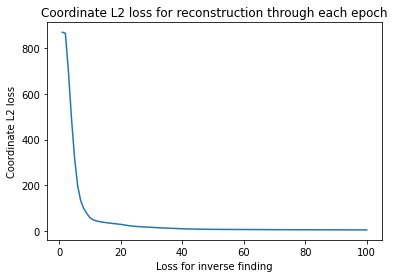

In [21]:
x = range(1,len(loss_list)+1)
plt.plot(x,loss_list)
plt.xlabel("Loss for inverse finding")
plt.ylabel("Coordinate L2 loss")
plt.title(f"Coordinate L2 loss for reconstruction through each epoch")

plt.savefig("Epoch-loss.png")
plt.show()

In [22]:
embedding = signet.embedding.cpu().detach().numpy()

Now we draw out the diagram for this helix, both the reconstruction one and the original one

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


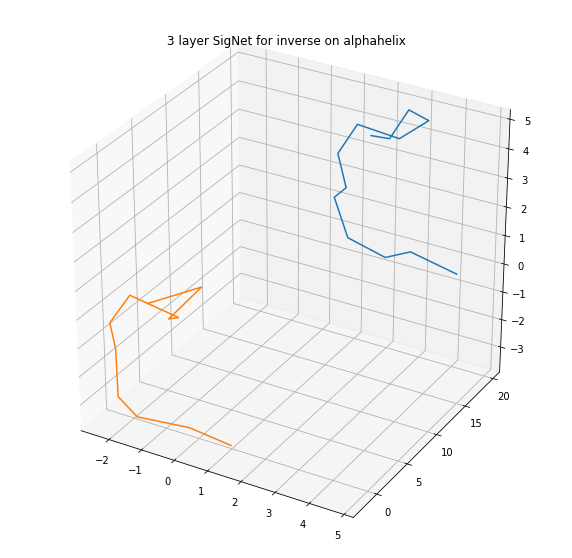

In [25]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

x1,y1,z1 = np.transpose(alpha_helix[0])
x2,y2,z2,t1 = np.transpose(embedding[0])

ax.plot(x1,y1,z1,label = "Original_alphaHelix")
ax.plot(x2,y2,z2,label = "Reconstruct_alphahelix")
ax.set_title(f"3 layer SigNet for inverse on alphahelix")
plt.savefig("Reconstruct_using DL.png")
plt.show()

Now we consider a deep signature network on this

In [26]:
class DeepSigNet(torch.nn.Module):
    def __init__(self, sig_depth,in_channels = 3,final_point = 13):
        super(DeepSigNet, self).__init__()
        self.embedding = None
        self.augment1 = signatory.Augment(in_channels=in_channels,
                          layer_sizes=(8,8,3),
                          kernel_size=1,
                          include_original=False,
                          include_time=True)
        # not including original and time break the curse for vanishing path
        self.signature1 = signatory.Signature(depth=sig_depth,
                                stream=True)

        # +5 because self.augment1 is used to add time, and 4 other
        # channels, as well
        sig_channels1 = signatory.signature_channels(channels=4,
                                depth=sig_depth)
        self.augment2 = signatory.Augment(in_channels=sig_channels1,
                          layer_sizes=(8,8,3),
                          kernel_size=1,
                          include_original=False,
                          include_time=False)
        
        self.signature2 = signatory.Signature(depth=final_point,stream=False)

    
    def forward(self, inp):
        # inp is a three dimensional tensor of shape (batch, stream, in_channels)
        inp = torch.tensor(inp, dtype=torch.float32)
        a = self.augment1(inp)
        if a.size(1) <= 1:
            raise RuntimeError("Given an input with too short a stream to take the"
                               " signature")
        # a in a three dimensional tensor of shape (batch, stream, in_channels + 5)
        b = self.signature1(a, basepoint=False)
        # b is a three dimensional tensor of shape (batch, stream, sig_channels1)
        embedding = self.augment2(b)
        
        # store the embedding for now, in tensor of shape (batch, in_channels, stream)
        self.embedding = embedding
        x = embedding
        if x.size(1) <= 1:
            raise RuntimeError("Given an input with too short a stream to take the"
                               " signature")
        
        # x in a three dimensional tensor of shape (batch, stream, in_channels + 1)
        y = self.signature2(x, basepoint=False)
        # y is a two dimensional tensor of shape (batch, sig_channels),
        # corresponding to the terms of the signature
        return y

In [27]:
iter_num = 100
epoch_num = 100
deep_depth = 7 # this will cause an explosion if >= 8

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
deepsignet = DeepSigNet(sig_depth = deep_depth,in_channels = dim, final_point = alpha_helix.shape[1]).to(device)
optimizer = torch.optim.Adam(deepsignet.parameters(), lr=0.0001)
my_loss = torch.nn.MSELoss(reduction = 'mean')
input_dummy_path = input_dummy_path.to(device)
gt_sig = torch.tensor(signatory.signature(alpha_helix,alpha_helix.shape[1]),dtype = torch.float32).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [30]:
# Training process
loss_list = []
for epoch in tqdm.tqdm(range(epoch_num)):
    running_loss = 0.0
    for iter in (range(iter_num)):
        optimizer.zero_grad()
        outputs = deepsignet(input_dummy_path)
        loss = my_loss(outputs, gt_sig)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # print statistics
    print("loss: ", running_loss/iter_num)
    loss_list.append(running_loss/iter_num)
    running_loss = 0

  1%|          | 1/100 [00:06<10:31,  6.38s/it]

loss:  265.3622946166992


  2%|▏         | 2/100 [00:12<10:21,  6.34s/it]

loss:  265.1684857177734


  3%|▎         | 3/100 [00:19<10:16,  6.35s/it]

loss:  264.8939535522461


  4%|▍         | 4/100 [00:25<10:08,  6.34s/it]

loss:  264.73290069580077


  5%|▌         | 5/100 [00:31<10:02,  6.34s/it]

loss:  264.4274078369141


  6%|▌         | 6/100 [00:38<09:54,  6.33s/it]

loss:  264.304052734375


  7%|▋         | 7/100 [00:44<09:52,  6.37s/it]

loss:  264.1663052368164


  8%|▊         | 8/100 [00:50<09:43,  6.35s/it]

loss:  263.91573120117187


  9%|▉         | 9/100 [00:57<09:36,  6.34s/it]

loss:  263.5714630126953


 10%|█         | 10/100 [01:03<09:29,  6.33s/it]

loss:  263.7186349487305


 11%|█         | 11/100 [01:09<09:22,  6.32s/it]

loss:  263.6199661254883


 12%|█▏        | 12/100 [01:15<09:15,  6.31s/it]

loss:  263.45299865722654


 13%|█▎        | 13/100 [01:22<09:08,  6.31s/it]

loss:  263.11494110107424


 14%|█▍        | 14/100 [01:28<09:02,  6.31s/it]

loss:  263.18602600097654


 15%|█▌        | 15/100 [01:34<08:55,  6.30s/it]

loss:  262.87243499755857


 16%|█▌        | 16/100 [01:41<08:49,  6.30s/it]

loss:  262.8175415039062


 17%|█▋        | 17/100 [01:47<08:43,  6.30s/it]

loss:  262.6620745849609


 18%|█▊        | 18/100 [01:53<08:37,  6.31s/it]

loss:  262.53748596191406


 19%|█▉        | 19/100 [02:00<08:30,  6.30s/it]

loss:  262.4392315673828


 20%|██        | 20/100 [02:06<08:24,  6.31s/it]

loss:  262.2802182006836


 21%|██        | 21/100 [02:12<08:18,  6.31s/it]

loss:  262.16532135009766


 22%|██▏       | 22/100 [02:19<08:12,  6.31s/it]

loss:  262.0875524902344


 23%|██▎       | 23/100 [02:25<08:05,  6.31s/it]

loss:  262.1439993286133


 24%|██▍       | 24/100 [02:31<08:01,  6.34s/it]

loss:  261.8896923828125


 25%|██▌       | 25/100 [02:38<07:54,  6.32s/it]

loss:  261.6939428710937


 26%|██▌       | 26/100 [02:44<07:47,  6.32s/it]

loss:  261.63937591552735


 27%|██▋       | 27/100 [02:50<07:41,  6.32s/it]

loss:  261.36946472167966


 28%|██▊       | 28/100 [02:57<07:34,  6.32s/it]

loss:  261.6364663696289


 29%|██▉       | 29/100 [03:03<07:28,  6.32s/it]

loss:  261.32421417236327


 30%|███       | 30/100 [03:09<07:22,  6.32s/it]

loss:  261.17093170166015


 31%|███       | 31/100 [03:15<07:15,  6.31s/it]

loss:  261.16524993896485


 32%|███▏      | 32/100 [03:22<07:09,  6.32s/it]

loss:  261.01038665771483


 33%|███▎      | 33/100 [03:28<07:03,  6.32s/it]

loss:  260.86379608154294


 34%|███▍      | 34/100 [03:34<06:56,  6.31s/it]

loss:  260.80710235595706


 35%|███▌      | 35/100 [03:41<06:49,  6.30s/it]

loss:  260.7326501464844


 36%|███▌      | 36/100 [03:47<06:43,  6.30s/it]

loss:  260.7113656616211


 37%|███▋      | 37/100 [03:53<06:37,  6.30s/it]

loss:  260.6520880126953


 38%|███▊      | 38/100 [04:00<06:30,  6.30s/it]

loss:  260.5245181274414


 39%|███▉      | 39/100 [04:06<06:24,  6.30s/it]

loss:  260.251701965332


 40%|████      | 40/100 [04:12<06:18,  6.30s/it]

loss:  260.3522055053711


 41%|████      | 41/100 [04:18<06:12,  6.31s/it]

loss:  260.1163629150391


 42%|████▏     | 42/100 [04:25<06:08,  6.34s/it]

loss:  260.0500289916992


 43%|████▎     | 43/100 [04:31<06:00,  6.33s/it]

loss:  259.6935513305664


 44%|████▍     | 44/100 [04:38<05:53,  6.32s/it]

loss:  260.0362280273437


 45%|████▌     | 45/100 [04:44<05:47,  6.32s/it]

loss:  259.8428256225586


 46%|████▌     | 46/100 [04:50<05:41,  6.32s/it]

loss:  259.6512692260742


 47%|████▋     | 47/100 [04:56<05:34,  6.31s/it]

loss:  259.75203002929686


 48%|████▊     | 48/100 [05:03<05:28,  6.31s/it]

loss:  259.62952728271483


 49%|████▉     | 49/100 [05:09<05:22,  6.31s/it]

loss:  259.25635192871096


 50%|█████     | 50/100 [05:15<05:15,  6.31s/it]

loss:  259.47044555664064


 51%|█████     | 51/100 [05:22<05:09,  6.31s/it]

loss:  259.21360778808594


 52%|█████▏    | 52/100 [05:28<05:03,  6.31s/it]

loss:  259.04855850219724


 53%|█████▎    | 53/100 [05:34<04:56,  6.32s/it]

loss:  259.0816412353516


 54%|█████▍    | 54/100 [05:41<04:50,  6.32s/it]

loss:  259.1974169921875


 55%|█████▌    | 55/100 [05:47<04:44,  6.32s/it]

loss:  258.7870318603516


 56%|█████▌    | 56/100 [05:53<04:37,  6.31s/it]

loss:  258.73980361938476


 57%|█████▋    | 57/100 [06:00<04:31,  6.30s/it]

loss:  258.6905485534668


 58%|█████▊    | 58/100 [06:06<04:25,  6.32s/it]

loss:  258.6699166870117


 59%|█████▉    | 59/100 [06:12<04:19,  6.33s/it]

loss:  258.40207595825194


 60%|██████    | 60/100 [06:19<04:12,  6.32s/it]

loss:  258.51032821655275


 61%|██████    | 61/100 [06:25<04:06,  6.31s/it]

loss:  258.37182159423827


 62%|██████▏   | 62/100 [06:31<04:00,  6.32s/it]

loss:  258.12629440307614


 63%|██████▎   | 63/100 [06:38<03:53,  6.31s/it]

loss:  258.30992965698243


 64%|██████▍   | 64/100 [06:44<03:47,  6.31s/it]

loss:  258.05056503295896


 65%|██████▌   | 65/100 [06:50<03:40,  6.29s/it]

loss:  258.0175015258789


 66%|██████▌   | 66/100 [06:56<03:33,  6.29s/it]

loss:  257.76994750976564


 67%|██████▋   | 67/100 [07:03<03:27,  6.29s/it]

loss:  257.8468276977539


 68%|██████▊   | 68/100 [07:09<03:21,  6.30s/it]

loss:  257.5487016296387


 68%|██████▊   | 68/100 [07:12<03:23,  6.36s/it]


KeyboardInterrupt: ignored

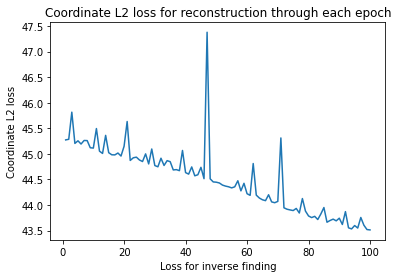

In [ ]:
x = range(1,len(loss_list)+1)
plt.plot(x,loss_list)
plt.xlabel("Loss for inverse finding")
plt.ylabel("Coordinate L2 loss")
plt.title(f"Coordinate L2 loss for reconstruction through each epoch")

plt.savefig("Epoch-loss.png")
plt.show()

In [ ]:
embedding = deepsignet.embedding.cpu().detach().numpy()

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


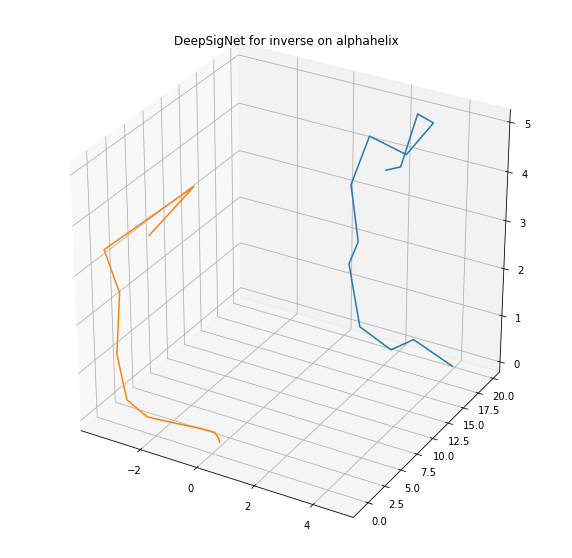

In [ ]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

x1,y1,z1 = np.transpose(alpha_helix[0])
x2,y2,z2 = np.transpose(embedding[0])

ax.plot(x1,y1,z1,label = "Original_alphaHelix")
ax.plot(x2,y2,z2,label = "Reconstruct_alphahelix")
ax.set_title(f"DeepSigNet for inverse on alphahelix")
plt.savefig("Reconstruct_using DSN.png")
plt.show()